# Setup

In [1]:
# Common imports
import sys
import os
import random
import sklearn
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import PIL

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_random_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib.pyplot as plt

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Directories
localDir = 'images/lego/'

# Images
imgWidth = 64
imgHeight = 64

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

# Make images into multidimensional arrays

In [2]:
def convertImageToArray(fileName):
    an_image = PIL.Image.open(fileName).convert('L')
    image_sequence = an_image.getdata()
    return np.array(image_sequence).reshape(imgWidth, imgHeight)

In [3]:
IndexToBrickId = {}
brickIdImageKeyPairs = []

for index, key in enumerate(os.listdir(localDir)):
    print(key)
    IndexToBrickId[index] = key
    
    fileList = os.listdir(localDir + key)
    listLenStr = str(len(fileList))
    for index2, fileName in enumerate(fileList):
        filePath = localDir + key + '/' + fileName
        print(str(index2+1).zfill(len(listLenStr)) + '/' + listLenStr + ' - ' + filePath + (' ' * 256), end='\r')
        brickIdImageKeyPairs.append((index, convertImageToArray(filePath)))
    print(listLenStr + '/' + listLenStr + ' - Finished converting' + (' ' * 256))
print('\nFinished converting all')

3001


1621/1621 - Finished converting                                                                                                                                                                                                                                                                
3003


1322/1322 - Finished converting                                                                                                                                                                                                                                                                
3004


1627/1627 - Finished converting                                                                                                                                                                                                                                                                

Finished converting all


# Randomize order

In [4]:
brickIdIndexes = []
images = []

random.shuffle(brickIdImageKeyPairs)
for item in brickIdImageKeyPairs:
    brickIdIndexes.append(item[0])
    images.append(item[1])

In [5]:
print(brickIdIndexes[0])
print(IndexToBrickId[0])
print(images[0] / 255)
print(len(images[0]))

2
3001
[[0.41176471 0.40784314 0.41176471 ... 0.49803922 0.49803922 0.49803922]
 [0.43137255 0.43137255 0.43529412 ... 0.49803922 0.49803922 0.49803922]
 [0.45098039 0.45882353 0.46666667 ... 0.49803922 0.49411765 0.49411765]
 ...
 [0.43529412 0.43137255 0.43137255 ... 0.46666667 0.46666667 0.46666667]
 [0.43529412 0.43137255 0.43137255 ... 0.46666667 0.46666667 0.46666667]
 [0.43529412 0.43529412 0.43137255 ... 0.46666667 0.46666667 0.46666667]]
64


# Machine Learning
Decision forest

In [6]:
percentageToTakeTrainFull = int(len(brickIdIndexes) * 0.9)
print('Train ' + str(percentageToTakeTrainFull) + '/' + str(len(brickIdIndexes)))
X_train_full = np.asarray(images[:percentageToTakeTrainFull])
y_train_full = np.asarray(brickIdIndexes[:percentageToTakeTrainFull])
X_test = np.asarray(images[percentageToTakeTrainFull:])
y_test = np.asarray(brickIdIndexes[percentageToTakeTrainFull:])

Train 4113/4570


In [7]:
# Show the size and dimension of the dataset.
X_train_full.shape

(4113, 64, 64)

In [8]:
# Each pixel intensity is represented as a byte (0 to 255).
X_train_full.dtype

dtype('int64')

In [9]:
percentageToTakeForValidation = len(X_test)
print('Validate ' + str(percentageToTakeForValidation) + '/' + str(len(X_train_full)))

# Split the full training set into a validation set and a (smaller) training set,
# and scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.
X_valid, X_train = X_train_full[:percentageToTakeForValidation] / 255., X_train_full[percentageToTakeForValidation:] / 255.
y_valid, y_train = y_train_full[:percentageToTakeForValidation], y_train_full[percentageToTakeForValidation:]
X_test = X_test / 255.

Validate 457/4113


In [10]:
X_train.shape

(3656, 64, 64)

In [11]:
X_valid.shape

(457, 64, 64)

In [12]:
X_test.shape

(457, 64, 64)

# Show random image and class

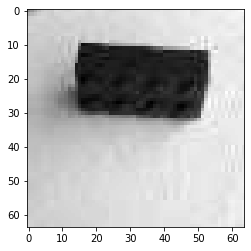

In [13]:
#Plot an image using Matplotlib's imshow() function, with a gray color map:
plt.imshow(X_train[0], cmap='gray')
plt.show()

In [14]:
# Show the name of the first image in the training set.
IndexToBrickId[y_train[0]]

'3001'

## Standardize the data
Because we want to use the SELU activation function and LeCun weight initializer, we should standardize all the input features to a mean of 0 and a standard deviation of 1. Since each pixel is an input feature, there are 28x28=784 input features, and we need to compute the mean and standard deviation for each of them.

In [15]:
# Compute the mean for each pixel.
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_means.shape

(1, 64, 64)

In [16]:
# Compute the standard deviation for each pixel.
pixel_stds = X_train.std(axis=0, keepdims=True)
pixel_stds.shape

(1, 64, 64)

In [17]:
# Scale the inputs to mean 0 and standard deviation 1 to achieve self-normalization with SELU and LeCun.
X_train_standardized = (X_train - pixel_means) / pixel_stds
X_valid_standardized = (X_valid - pixel_means) / pixel_stds
X_test_standardized = (X_test - pixel_means) / pixel_stds

In [18]:
# Validate that the mean is close to 0 for each pixel.
X_train_standardized.mean(axis=0, keepdims=True)

array([[[-8.57110395e-14, -7.29785033e-14, -1.97107329e-14, ...,
          2.00888115e-13,  1.69422869e-13,  1.74454554e-13],
        [-4.02238721e-14, -1.97090095e-14,  1.59698264e-14, ...,
          2.19366799e-13,  1.94306574e-13,  1.74568380e-13],
        [ 1.69246607e-14,  2.99343731e-14,  4.84232002e-14, ...,
          2.22709570e-13,  2.15326731e-13,  2.05801087e-13],
        ...,
        [-2.19909875e-13, -2.18220962e-13, -2.15515622e-13, ...,
          1.77653610e-14,  1.51630364e-14,  2.59682904e-14],
        [-2.19126188e-13, -2.16284377e-13, -2.19486742e-13, ...,
          1.09019437e-14,  1.42686187e-14,  1.97282642e-14],
        [-2.18949738e-13, -2.17603999e-13, -2.15826277e-13, ...,
          4.88128980e-15,  9.63937153e-15,  1.72048147e-14]]])

In [19]:
# Validate that the standard deviation is close to 1 for each pixel.
X_train_standardized.std(axis=0, keepdims=True)

array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]])

# Create a model using the Sequential API

In [20]:
model = keras.models.Sequential([
# Input layer:
# A "Flatten" layer converts each input image into a 1-dimensional array.
keras.layers.Flatten(input_shape=[imgWidth, imgHeight]),

# Hidden layers:
# A dense layer is fully connected.
keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),

# Output layer.
# The layer contains one neuron per class (i.e. 10).
# Since it is multiclass classification, we should use the softmax activation function.
# It will ensure that the estimated probabilities are between 0 and 1, and that the sum
# of estimated probabilities for one prediction is 1.
# (for binary classification we would have a single output neuron using the logistic activation function).
keras.layers.Dense(10, activation="softmax")])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Show information about the model

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               409700    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 410,710
Trainable params: 410,710
Non-trainable params: 0
_________________________________________________________________


In [22]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [23]:
weights, biases = hidden1.get_weights()

In [24]:
weights

array([[ 0.00432948, -0.00604748, -0.01355498, ...,  0.0313711 ,
         0.0210361 , -0.01968222],
       [-0.00331386,  0.02714479,  0.00605793, ..., -0.00820307,
        -0.0015005 ,  0.00929759],
       [ 0.0123916 , -0.00726546, -0.01654809, ...,  0.00102897,
        -0.00280138, -0.012999  ],
       ...,
       [ 0.00801637, -0.01194383,  0.01962937, ..., -0.00078325,
        -0.00886501, -0.0114204 ],
       [ 0.02857949, -0.0179805 ,  0.02305402, ..., -0.0273807 ,
        -0.00071307,  0.01193039],
       [-0.02891995,  0.0036936 ,  0.01000366, ..., -0.01802048,
        -0.00291577, -0.01598471]], dtype=float32)

In [25]:
weights.shape

(4096, 100)

In [26]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [27]:
biases.shape

(100,)

## Compile the model
You must at least specify the loss function and the optimizer to use. You can also specify a list of additional metrics to use during training and evaluation.

In [28]:
# "sparse_categorical_crossentropy" is the loss function to use for classification when the classes are exclusive.
# "sgd" means Stochastic Gradient Descent.
# "accuracy" enables us to measure the accuracy during training and evaluation.
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(momentum=0.9),
              metrics=["accuracy"])

## Train the model

In [29]:
# EarlyStopping (with rollback to the best model).
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# Performance scheduling
# (multiply the learning rate by a factor when the error stops dropping for a number of epochs, called patience)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=4)

# Train the model with early stopping or performance scheduling or both. Training is much faster when
# early stopping is used, but a slightly better accuracy is achieved with performance scheduling alone.
history = model.fit(X_train_standardized, y_train, epochs=30,
                    validation_data=(X_valid_standardized, y_valid),
                    callbacks=[lr_scheduler, early_stopping])

Train on 3656 samples, validate on 457 samples
Epoch 1/30
3656/3656 [==============================] - 1s 250us/sample - loss: 1.1901 - acc: 0.9111 - val_loss: 0.9583 - val_acc: 0.9781
Epoch 2/30
3656/3656 [==============================] - 1s 200us/sample - loss: 0.7490 - acc: 0.9809 - val_loss: 2.0630e-06 - val_acc: 1.0000
Epoch 3/30
3656/3656 [==============================] - 1s 203us/sample - loss: 0.1210 - acc: 0.9880 - val_loss: 0.0553 - val_acc: 0.9934
Epoch 4/30
3656/3656 [==============================] - 1s 197us/sample - loss: 0.2303 - acc: 0.9877 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 5/30
3656/3656 [==============================] - 1s 202us/sample - loss: 0.0376 - acc: 0.9934 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 6/30
3656/3656 [==============================] - 1s 204us/sample - loss: 0.0218 - acc: 0.9929 - val_loss: 0.0033 - val_acc: 1.0000
Epoch 7/30
3656/3656 [==============================] - 1s 184us/sample - loss: 0.0139 - acc: 0.9948 - val_loss: 0.0026 -

In [30]:
# The fit() method returns a history object with information about the result of the training.
history.params

{'batch_size': 32,
 'epochs': 30,
 'steps': None,
 'samples': 3656,
 'verbose': 0,
 'do_validation': True,
 'metrics': ['loss', 'acc', 'val_loss', 'val_acc']}

In [31]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6]


In [32]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])

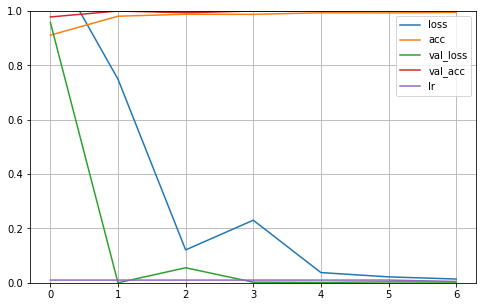

In [33]:
# Show the learning curves.
# (The training curves should be shifted half an epoch to the left to be completely comparable with
# the validation curves).

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Evaluate the model.

In [34]:
model.evaluate(X_test_standardized, y_test)

457/457 [==============================] - 0s 121us/sample - loss: 0.1164 - acc: 0.9912


[0.1164058056218, 0.99124724]

In [35]:
# Make predictions with probabilities for the first 3 instances in the test set.
X_new = X_test_standardized[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [36]:
# Make predictions without probabilities.
y_pred = model.predict_classes(X_new)
y_pred

array([1, 2, 0])

In [37]:
# Check if the predictions were coorrect.
y_new = y_test[:3]
y_new

array([1, 2, 0])

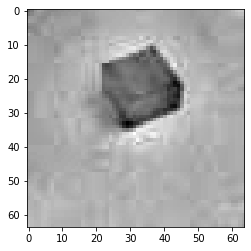

3003


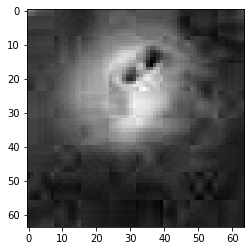

3004


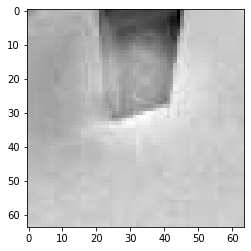

3001


In [38]:
# Compare image and classes.
newClassList = np.array(list(IndexToBrickId.values()))[y_pred]

for i in range(3):
    plt.imshow(X_new[i], cmap='gray')
    plt.show()
    print(newClassList[i])

# Randomized Search Report

In [39]:
def build_classifier(layerCount=1, 
                     neuronCount=100, 
                     activationFunction='relu', 
                     kernelInitializer='glorot_uniform',
                     outputNeuronCount=10,
                     optimizer='sgd', 
                     learningRate=0.005, 
                     momentum = 0.0):
    model = keras.models.Sequential()
    
    model.add(keras.layers.Flatten(input_shape=[imgWidth, imgHeight]))

    kernelInitializerFound = 'lecun_normal' if activationFunction == 'selu' else kernelInitializer
    for layerIndex in range(layerCount):
        model.add(keras.layers.Dense(units=neuronCount, activation=activationFunction, kernel_initializer=kernelInitializerFound)),
    
    # Softmax is default for multiclass classification.
    model.add(keras.layers.Dense(units=outputNeuronCount, activation="softmax"))
    
    foundOptimizer = optimizer
    if optimizer == 'sgd':
        foundOptimizer=keras.optimizers.SGD(lr=learningRate, momentum=momentum)
    elif optimizer == 'adam':
        foundOptimizer=keras.optimizers.Adam(learning_rate=learningRate)
    
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=foundOptimizer,
                  metrics=["accuracy"])
            
    return model

In [46]:
# TAKES FOREVER TO RUN

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

# EarlyStopping (with rollback to the best model).
class_early_stopping = keras.callbacks.EarlyStopping(patience=5, min_delta=0.001, restore_best_weights=True)

# Performance scheduling
# (multiply the learning rate by a factor when the error stops dropping for a number of epochs, called patience)
class_lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=4)

classifier = KerasClassifier(build_fn=build_classifier)
params = dict(layerCount=[1],#, 2, 3],
            neuronCount=[50],#, 100, 150],
            activationFunction=['relu'],#, 'selu'],
            kernelInitializer=['glorot_normal'],#, 'random_normal'],
            outputNeuronCount=[5],#, 10, 15],
            optimizer=['sgd'],#, 'adam'],
            learningRate=[0.01],#, 0.1, 1],
            momentum = [0.0, 0.9])#, 0.5]

gcv = GridSearchCV(classifier, param_grid=params, cv=3)
gcv.fit(X_train_standardized, y_train,
         validation_data=(X_valid_standardized, y_valid),
         epochs=30, verbose=1,
         callbacks=[class_lr_scheduler, class_early_stopping])

Train on 2437 samples, validate on 457 samples
Epoch 1/30
2437/2437 [==============================] - 1s 310us/sample - loss: 0.3255 - acc: 0.9360 - val_loss: 0.0579 - val_acc: 1.0000
Epoch 2/30
2437/2437 [==============================] - 0s 150us/sample - loss: 0.0845 - acc: 0.9902 - val_loss: 0.0283 - val_acc: 1.0000
Epoch 3/30
2437/2437 [==============================] - 0s 160us/sample - loss: 0.0397 - acc: 0.9947 - val_loss: 0.0211 - val_acc: 0.9978
Epoch 4/30
2437/2437 [==============================] - 0s 141us/sample - loss: 0.0216 - acc: 0.9979 - val_loss: 0.0129 - val_acc: 1.0000
Epoch 5/30
2437/2437 [==============================] - 0s 143us/sample - loss: 0.0140 - acc: 0.9996 - val_loss: 0.0112 - val_acc: 1.0000
Epoch 6/30
2437/2437 [==============================] - 0s 138us/sample - loss: 0.0139 - acc: 0.9979 - val_loss: 0.0083 - val_acc: 1.0000
Epoch 7/30
2437/2437 [==============================] - 0s 138us/sample - loss: 0.0091 - acc: 0.9996 - val_loss: 0.0070 - val

Epoch 15/30
2438/2438 [==============================] - 0s 145us/sample - loss: 0.0043 - acc: 1.0000 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 16/30
2438/2438 [==============================] - 0s 152us/sample - loss: 0.0039 - acc: 1.0000 - val_loss: 0.0026 - val_acc: 1.0000
Epoch 17/30
2438/2438 [==============================] - 0s 154us/sample - loss: 0.0035 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 18/30
2438/2438 [==============================] - 0s 160us/sample - loss: 0.0033 - acc: 1.0000 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 19/30
2438/2438 [==============================] - 0s 146us/sample - loss: 0.0032 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 20/30
1218/1218 [==============================] - 0s 83us/sample - loss: 0.0152 - acc: 0.9967
Train on 2437 samples, validate on 457 samples
Epoch 1/30
2437/2437 [==============================] - 1s 349us/sample - loss: 0.4952 - acc: 0.9298 - val_loss: 0.0087 - val_acc: 0.9956
Epoch 2/30
2437/243

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f3772c74828>,
             param_grid={'activationFunction': ['relu'],
                         'kernelInitializer': ['glorot_normal'],
                         'layerCount': [1], 'learningRate': [0.01],
                         'momentum': [0.0, 0.9], 'neuronCount': [50],
                         'optimizer': ['sgd'], 'outputNeuronCount': [5]})

In [47]:
pd.concat([pd.DataFrame(gcv.cv_results_["params"]),
           pd.DataFrame(gcv.cv_results_["mean_test_score"], columns=["Accuracy"])], axis=1
         ).sort_values(by='Accuracy', ascending=False)

,activationFunction,kernelInitializer,layerCount,learningRate,momentum,neuronCount,optimizer,outputNeuronCount,Accuracy
0,relu,glorot_normal,1,0.01,0.0,50,sgd,5,0.996171
1,relu,glorot_normal,1,0.01,0.9,50,sgd,5,0.990428
